# A notebook for cumulative sc graphs

In [6]:
import napari
from cellpose import models
from octopuslite import utils, tile
import numpy as np
import os

def view(img):
    return napari.Viewer().add_image(img)
from napari_animation import Animation
from tqdm.auto import tqdm

import btrack
import dask.array as da

from skimage.transform import rescale, resize, downscale_local_mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
sns.set_palette("Spectral")

from macrohet import tools

### Load all metadata

Both the image metadata and the assay layout metadata

In [7]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
image_metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(image_metadata_fn)
assay_layout_metadata = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
assay_layout = utils.read_harmony_metadata(assay_layout_metadata, assay_layout=True)
assay_layout

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

# Iteratively load all tracks

and append to a track_dict dictionary

In [8]:
tracks_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):
    ### load tracks
    with btrack.dataio.HDF5FileHandler(
            f"/mnt/DATA/macrohet/labels/tracks_objs/({row},{column})_tracks_rescaled.h5", 
            'r', 
            obj_type = 'obj_type_1', 
            ) as hdf: 
            tracks = hdf.tracks
            objs = hdf.objects
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/03/15 04:53:38 PM] Opening HDF file: /mnt/DATA/macrohet/labels/tracks_objs/(3,4)_tracks_rescaled.h5...
[INFO][2023/03/15 04:53:38 PM] Loading tracks/obj_type_1
[INFO][2023/03/15 04:53:38 PM] Loading LBEP/obj_type_1
[INFO][2023/03/15 04:53:38 PM] Loading objects/obj_type_1 (29079, 5) (29079 filtered: None)
[INFO][2023/03/15 04:53:38 PM] Loading objects/obj_type_1 (29079, 5) (29079 filtered: None)
[INFO][2023/03/15 04:53:39 PM] Closing HDF file: /mnt/DATA/macrohet/labels/tracks_objs/(3,4)_tracks_rescaled.h5
[INFO][2023/03/15 04:53:39 PM] Opening HDF file: /mnt/DATA/macrohet/labels/tracks_objs/(3,5)_tracks_rescaled.h5...
[INFO][2023/03/15 04:53:39 PM] Loading tracks/obj_type_1
[INFO][2023/03/15 04:53:39 PM] Loading LBEP/obj_type_1
[INFO][2023/03/15 04:53:39 PM] Loading objects/obj_type_1 (30240, 5) (30240 filtered: None)
[INFO][2023/03/15 04:53:39 PM] Loading objects/obj_type_1 (30240, 5) (30240 filtered: None)
[INFO][2023/03/15 04:53:40 PM] Closing HDF file: /mnt/DATA/macrohe

[INFO][2023/03/15 04:53:53 PM] Closing HDF file: /mnt/DATA/macrohet/labels/tracks_objs/(5,7)_tracks_rescaled.h5
[INFO][2023/03/15 04:53:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/tracks_objs/(5,8)_tracks_rescaled.h5...
[INFO][2023/03/15 04:53:53 PM] Loading tracks/obj_type_1
[INFO][2023/03/15 04:53:53 PM] Loading LBEP/obj_type_1
[INFO][2023/03/15 04:53:53 PM] Loading objects/obj_type_1 (30332, 5) (30332 filtered: None)
[INFO][2023/03/15 04:53:53 PM] Loading objects/obj_type_1 (30332, 5) (30332 filtered: None)
[INFO][2023/03/15 04:53:53 PM] Closing HDF file: /mnt/DATA/macrohet/labels/tracks_objs/(5,8)_tracks_rescaled.h5
[INFO][2023/03/15 04:53:53 PM] Opening HDF file: /mnt/DATA/macrohet/labels/tracks_objs/(5,9)_tracks_rescaled.h5...
[INFO][2023/03/15 04:53:53 PM] Loading tracks/obj_type_1
[INFO][2023/03/15 04:53:53 PM] Loading LBEP/obj_type_1
[INFO][2023/03/15 04:53:53 PM] Loading objects/obj_type_1 (25139, 5) (25139 filtered: None)
[INFO][2023/03/15 04:53:54 PM] Loading objects

# Compile all longer length tracks into dataframe

Add extra information such as the MSD of cells between frames

In [9]:
### list of track info dfs
dfs = list()
### empty dictionary for filtered tracks
filtered_tracks = dict()
### iterate over all tracks
for key in tracks_dict.keys():
    ### extract tracks only with max length
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) >34] #== 75]
    ### iterate over full length tracks
    for track in filtered_tracks[key]:
        ### get info for assay layout
        info = assay_layout.loc[key]
        ### compile single track dictionary of info
        d = {'Time (hours)':track['t'], 
             'x':track['x'],
             'y':track['y'],
             'Area':track['area'], 
             'Intracellular Mtb content':track['mean_intensity-1'],
             'Macroph. GFP expression':track['mean_intensity-0'],
             'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
             'MSD': [tools.msd_calc(track['x'][i-1], 
                                    track['y'][i-1], 
                                    track['x'][i], 
                                    track['y'][i]) 
                      if i != 0 else 0
                      for i in range(0, len(track))],
             'Strain':[info['Strain'] for i in range(len(track['t']))], 
             'Compound':[info['Compound'] for i in range(len(track['t']))], 
             'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
             'Cell ID':[track.ID for i in range(len(track['t']))],
             'Acquisition ID':[key for i in range(len(track['t']))]}
        ### append df to list of dfs
        dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
df = pd.concat(dfs, ignore_index=True)
df

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID
0,0,1050.816895,19.046474,2539.0,0.005487,0.017871,0.912557,0.000000,RD1,CTRL,EC0,344,"(3, 4)"
1,1,1069.464722,16.152050,2098.0,0.005470,0.018236,0.870907,18.871119,RD1,CTRL,EC0,344,"(3, 4)"
2,2,1074.024780,16.110592,2143.0,0.005451,0.017062,0.884658,4.560247,RD1,CTRL,EC0,344,"(3, 4)"
3,3,1070.232544,12.069767,1591.0,0.005442,0.018409,0.905547,5.541599,RD1,CTRL,EC0,344,"(3, 4)"
4,4,1073.632935,13.351424,1861.0,0.005454,0.017631,0.922291,3.633910,RD1,CTRL,EC0,344,"(3, 4)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
348145,70,263.636963,1030.464722,2548.0,0.006251,0.035022,0.781741,6.429717,WT,BDQ,EC99,2035,"(6, 9)"
348146,71,270.823517,1039.534180,2516.0,0.006238,0.033061,0.789968,11.571587,WT,BDQ,EC99,2035,"(6, 9)"
348147,72,286.121796,1044.373535,2915.0,0.006036,0.029789,0.796342,16.045457,WT,BDQ,EC99,2035,"(6, 9)"
348148,73,290.993134,1048.557495,3200.0,0.005887,0.029728,0.643475,6.421484,WT,BDQ,EC99,2035,"(6, 9)"


# Create a separate df for "survivor" tracks

i.e. all tracks that last the length of the time lapse

In [10]:
### list of track info dfs
dfs = list()
### empty dictionary for filtered tracks
filtered_tracks = dict()
### iterate over all tracks
for key in tracks_dict.keys():
    ### extract tracks only with max length
    filtered_tracks[key] = [track for track in tracks_dict[key] if len(track) == 75]
    ### iterate over full length tracks
    for track in filtered_tracks[key]:
        ### get info for assay layout
        info = assay_layout.loc[key]
        ### compile single track dictionary of info
        d = {'Time (hours)':track['t'], 
             'x':track['x'],
             'y':track['y'],
             'Area':track['area'], 
             'Intracellular Mtb content':track['mean_intensity-1'],
             'Macroph. GFP expression':track['mean_intensity-0'],
             'Eccentricity':np.sqrt(1-((track['minor_axis_length']**2)/(track['major_axis_length']**2))),
             'MSD': [tools.msd_calc(track['x'][i-1], 
                                    track['y'][i-1], 
                                    track['x'][i], 
                                    track['y'][i]) 
                      if i != 0 else 0
                      for i in range(0, len(track))],
             'Strain':[info['Strain'] for i in range(len(track['t']))], 
             'Compound':[info['Compound'] for i in range(len(track['t']))], 
             'Concentration':[info['ConcentrationEC'] for i in range(len(track['t']))], 
             'Cell ID':[track.ID for i in range(len(track['t']))],
             'Acquisition ID':[key for i in range(len(track['t']))]}
        ### append df to list of dfs
        dfs.append(pd.DataFrame(d))
### concat single track dfs into big df
full_len_df = pd.concat(dfs, ignore_index=True)
full_len_df

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID
0,0,1169.847412,13.893421,760.0,0.005136,0.014705,0.809516,0.000000,RD1,CTRL,EC0,343,"(3, 4)"
1,1,1172.826538,14.674929,1049.0,0.005121,0.013235,0.843927,3.079926,RD1,CTRL,EC0,343,"(3, 4)"
2,2,1174.588867,14.375803,934.0,0.005116,0.013899,0.719524,1.787535,RD1,CTRL,EC0,343,"(3, 4)"
3,3,1175.250610,12.160207,774.0,0.005094,0.013428,0.739700,2.312308,RD1,CTRL,EC0,343,"(3, 4)"
4,4,1180.553955,9.897770,538.0,0.005071,0.012774,0.761300,5.765768,RD1,CTRL,EC0,343,"(3, 4)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81520,70,559.663025,1177.240234,3018.0,0.005635,0.024949,0.698306,3.245095,WT,BDQ,EC99,155,"(6, 9)"
81521,71,556.457581,1178.115601,2863.0,0.005609,0.024090,0.716728,3.322821,WT,BDQ,EC99,155,"(6, 9)"
81522,72,559.905823,1178.514648,3047.0,0.005600,0.022092,0.789115,3.471255,WT,BDQ,EC99,155,"(6, 9)"
81523,73,565.014221,1180.512939,2737.0,0.005606,0.021206,0.822009,5.485335,WT,BDQ,EC99,155,"(6, 9)"


### Add category to discern initial amount of Mtb growth

Categorical

In [11]:
initial_mtb = df.loc[df['Time (hours)'] == 0, 'Intracellular Mtb content']
initial_mtb_quartiles = pd.cut(initial_mtb, bins = [initial_mtb.quantile(.0), 
                                                    initial_mtb.quantile(.25), 
                                                    initial_mtb.quantile(0.5), 
                                                    initial_mtb.quantile(.75),
                                                    initial_mtb.quantile(1)], 
                                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
df['Initial Mtb load (quartile)'] = initial_mtb_quartiles
df.fillna(method='ffill', inplace=True)

### Mtb growth segregated by initial Mtb load -- for all tracks longer than half the timelapse

Text(0.5, 1.0, 'Cumulative single-macrophage intracellular Mtb growth, segregated by initial Mtb load')

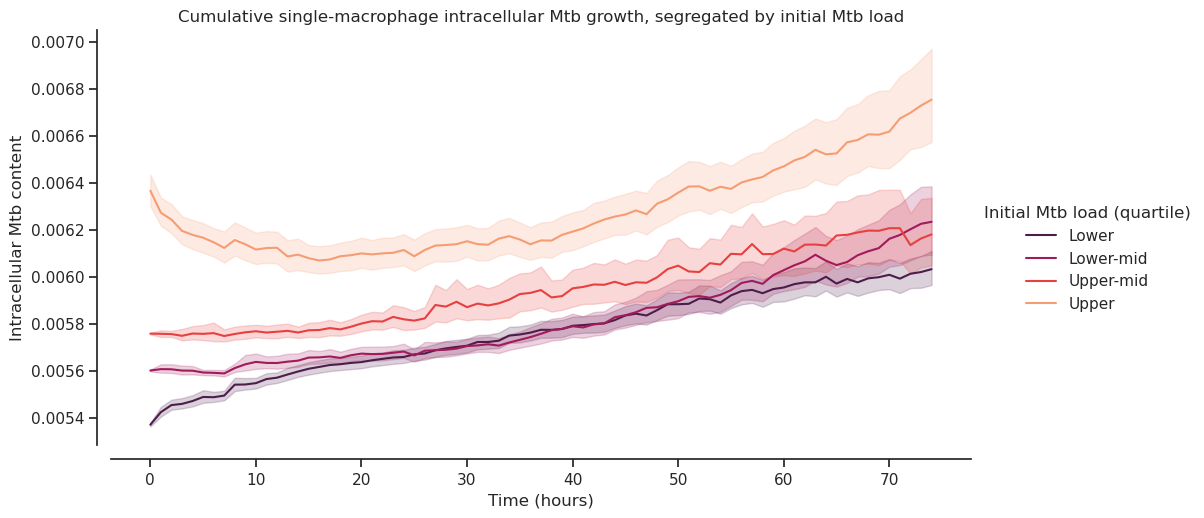

In [32]:
# sns.set_palette('RdYlGn')/
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Initial Mtb load (quartile)', kind = 'line',
            aspect = 2, alpha = 1, 
            palette=sns.color_palette('rocket', n_colors=4, ), 
            
           )
sns.despine(offset=10, trim=False)
plt.title('Cumulative single-macrophage intracellular Mtb growth, segregated by initial Mtb load')

### Same graph but for survivor tracks

In [14]:
initial_mtb = full_len_df.loc[full_len_df['Time (hours)'] == 0, 'Intracellular Mtb content']
initial_mtb_quartiles = pd.cut(initial_mtb, bins = [initial_mtb.quantile(.0), 
                                                    initial_mtb.quantile(.25), 
                                                    initial_mtb.quantile(0.5), 
                                                    initial_mtb.quantile(.75),
                                                    initial_mtb.quantile(1)], 
                                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
full_len_df['Initial Mtb load (quartile)'] = initial_mtb_quartiles
full_len_df.fillna(method='ffill', inplace=True)

Text(0.5, 1.0, 'Cumulative single-macrophage (survivors only) intracellular Mtb growth, segregated by initial Mtb load')

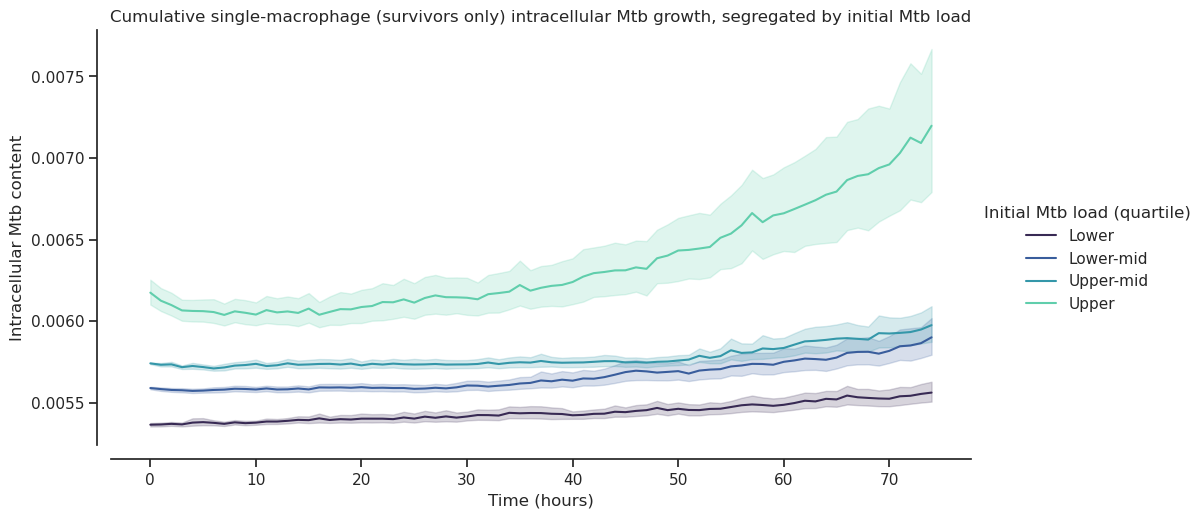

In [33]:
# sns.set_palette('RdYlGn')/
sns.relplot(data = full_len_df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Initial Mtb load (quartile)', kind = 'line',
            aspect = 2, alpha = 1, 
            palette=sns.color_palette('mako', n_colors=4, )            
           )
sns.despine(offset=10, trim=False)
plt.title('Cumulative single-macrophage (survivors only) intracellular Mtb growth, segregated by initial Mtb load')

# Now segregating on final Mtb load

In [30]:
final_mtb = df.loc[df['Time (hours)'] == 74, 'Intracellular Mtb content']
final_mtb_quartiles = pd.cut(final_mtb, bins = [final_mtb.quantile(.0), 
                                                    final_mtb.quantile(.25), 
                                                    final_mtb.quantile(0.5), 
                                                    final_mtb.quantile(.75),
                                                    final_mtb.quantile(1)], 
                                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
df['Final Mtb load (quartile)'] = final_mtb_quartiles
df.fillna(method='bfill', inplace=True)

Text(0.5, 1.0, 'Cumulative single-macrophage intracellular Mtb growth, segregated by final Mtb load')

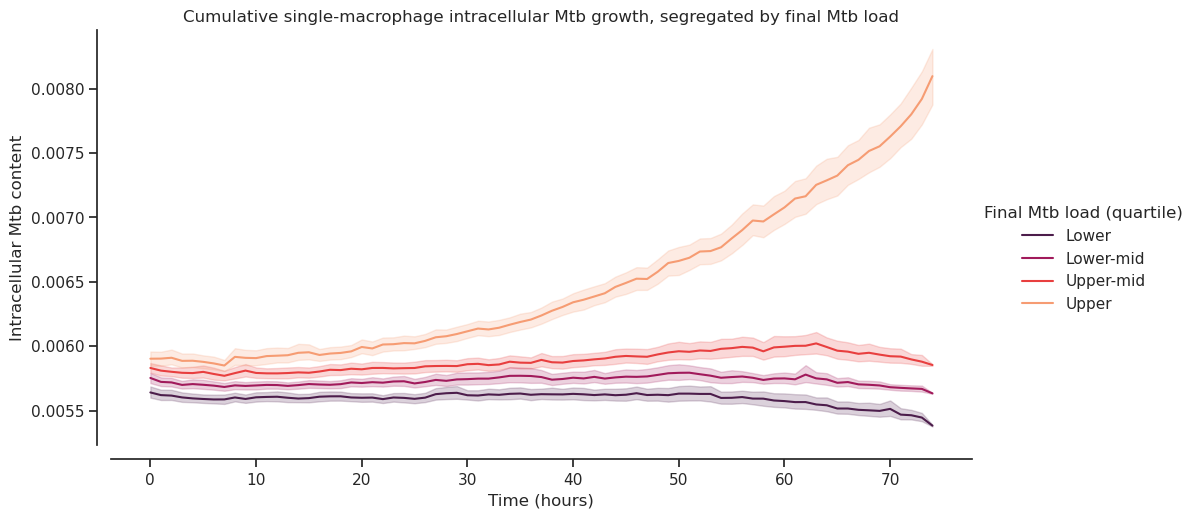

In [34]:
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Final Mtb load (quartile)', kind = 'line',
            aspect = 2,
            palette=sns.color_palette('rocket', n_colors=4, ), 
           )
sns.despine(offset=10, trim=False)
plt.title('Cumulative single-macrophage intracellular Mtb growth, segregated by final Mtb load')

### Now for survivor cells

In [35]:
final_mtb = full_len_df.loc[full_len_df['Time (hours)'] == 74, 'Intracellular Mtb content']
final_mtb_quartiles = pd.cut(final_mtb, bins = [final_mtb.quantile(.0), 
                                                    final_mtb.quantile(.25), 
                                                    final_mtb.quantile(0.5), 
                                                    final_mtb.quantile(.75),
                                                    final_mtb.quantile(1)], 
                                                    labels = ['Lower', 'Lower-mid', 'Upper-mid', 'Upper'])
full_len_df['Final Mtb load (quartile)'] = final_mtb_quartiles
full_len_df.fillna(method='bfill', inplace=True)

Text(0.5, 1.0, 'Cumulative single-macrophage (survivors only) intracellular Mtb growth, segregated by final Mtb load')

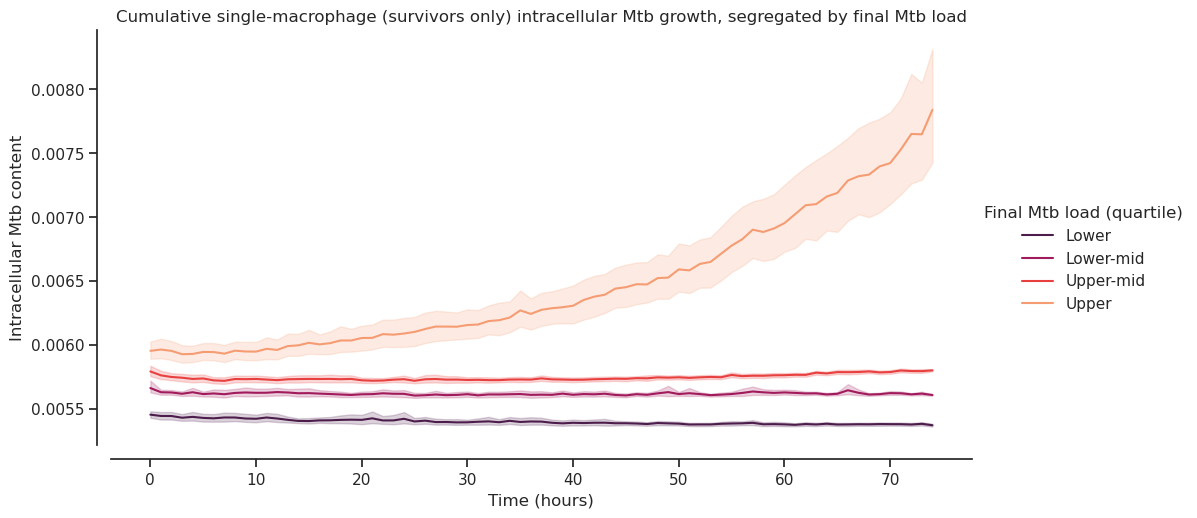

In [36]:
sns.relplot(data = full_len_df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Final Mtb load (quartile)', kind = 'line',
            aspect = 2,
            palette=sns.color_palette('rocket', n_colors=4, ), 
           )
sns.despine(offset=10, trim=False)
plt.title('Cumulative single-macrophage (survivors only) intracellular Mtb growth, segregated by final Mtb load')

Now continuous assessment: ie. the actual value of the Mtb content in the first frame

In [37]:
initial_mtb = df.loc[df['Time (hours)'] == 0, 'Intracellular Mtb content']
df['Initial Mtb load'] = initial_mtb
df.fillna(method='ffill', inplace=True)

In [38]:
final_mtb = df.loc[df['Time (hours)'] == 74, 'Intracellular Mtb content']
df['Final Mtb load'] = final_mtb
df.fillna(method='bfill', inplace=True)

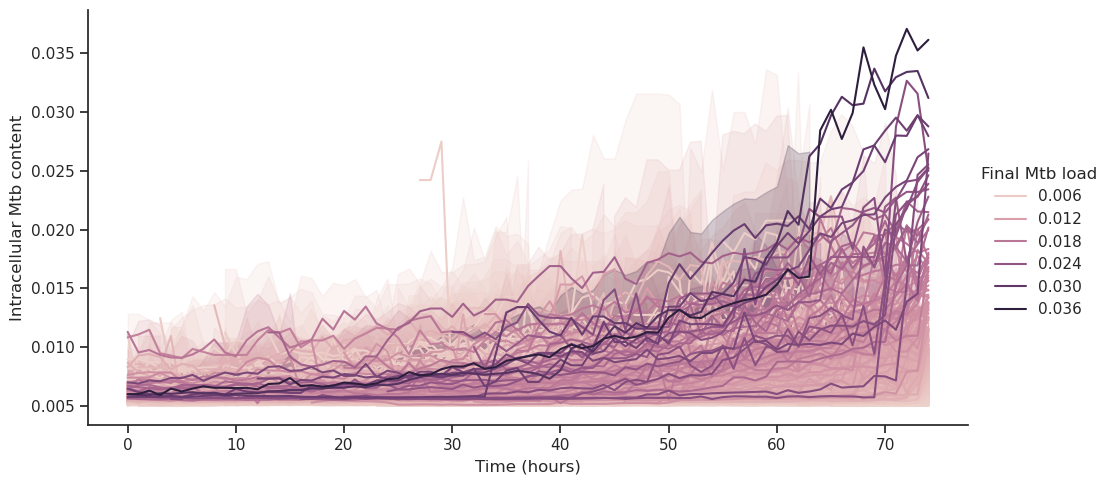

In [39]:
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Final Mtb load', kind = 'line',
            aspect = 2,
           )

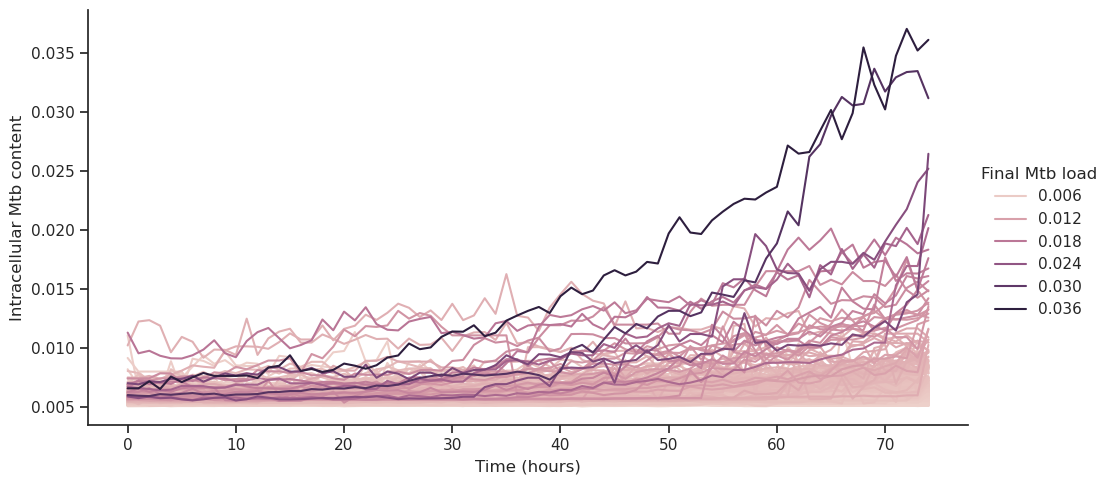

In [111]:
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Final Mtb load', kind = 'line',
            aspect = 2,
           )

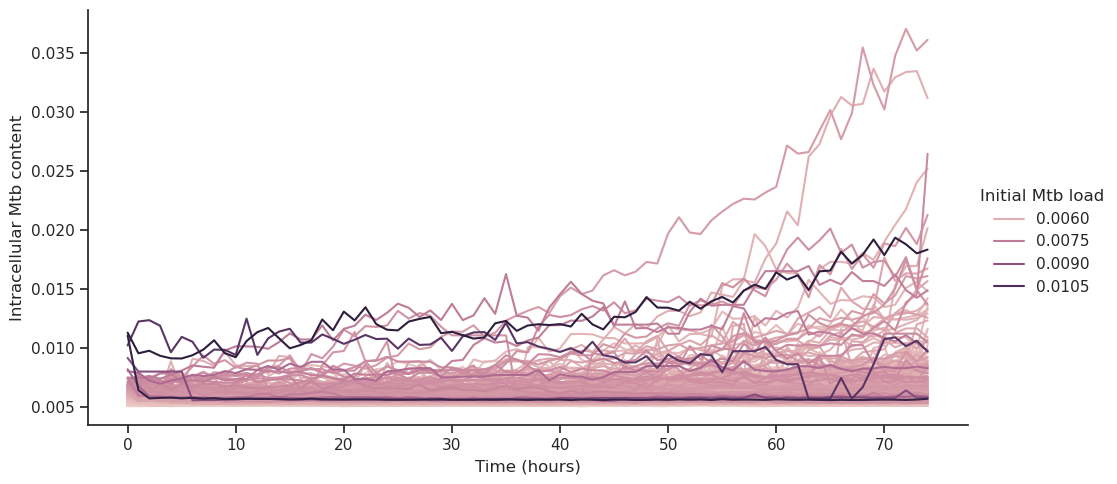

In [156]:
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Initial Mtb load', kind = 'line',
            aspect = 2,
           )

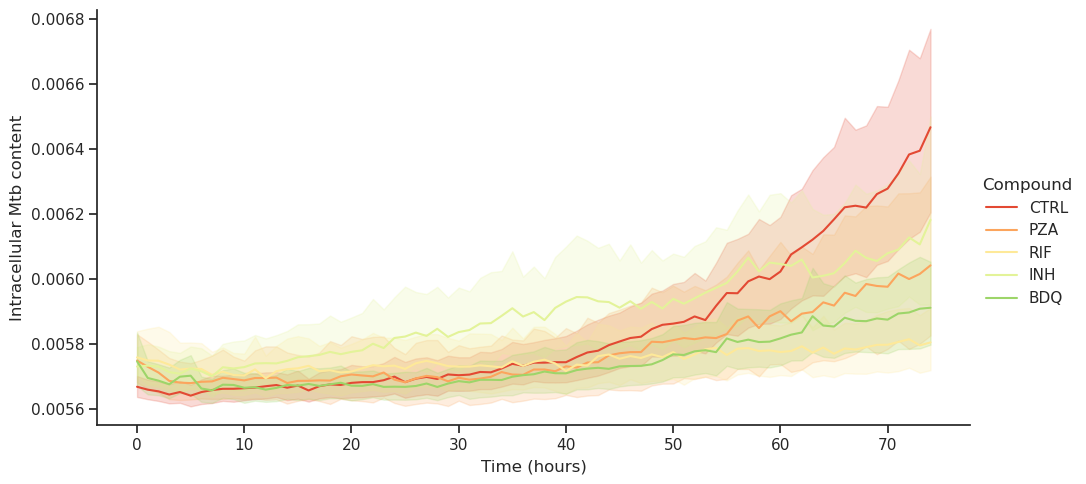

In [158]:
sns.relplot(data = df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Compound', kind = 'line',
            aspect = 2,
           )

## Pick a single experiment to focus on?

In [11]:
assay_layout

Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

In [40]:
## picking CTRL as example 
tracks_df = df[df['Acquisition ID']==(3,5)]
tracks_df

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Initial Mtb load (quartile),Final Mtb load (quartile),Initial Mtb load,Final Mtb load
13584,0,214.715118,649.776428,4602.0,0.005709,0.019985,0.630087,0.000000,WT,CTRL,EC0,311,"(3, 5)",Upper-mid,Upper-mid,0.005709,0.005765
13585,1,214.955872,648.901794,4329.0,0.005699,0.023402,0.777214,0.907164,WT,CTRL,EC0,311,"(3, 5)",Upper-mid,Upper-mid,0.005709,0.005765
13586,2,223.674240,650.713928,3877.0,0.005765,0.031596,0.599604,8.904705,WT,CTRL,EC0,311,"(3, 5)",Upper-mid,Upper-mid,0.005709,0.005765
13587,3,221.003372,652.696777,4449.0,0.005688,0.020448,0.548114,3.326443,WT,CTRL,EC0,311,"(3, 5)",Upper-mid,Upper-mid,0.005709,0.005765
13588,4,219.889526,644.160156,4571.0,0.005681,0.017730,0.519863,8.608981,WT,CTRL,EC0,311,"(3, 5)",Upper-mid,Upper-mid,0.005709,0.005765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28554,70,427.750946,949.322754,1072.0,0.005310,0.024622,0.776626,2.432187,WT,CTRL,EC0,2102,"(3, 5)",Lower,Lower,0.005101,0.005259
28555,71,428.007202,949.946960,1112.0,0.005436,0.027250,0.811426,0.674760,WT,CTRL,EC0,2102,"(3, 5)",Lower,Lower,0.005101,0.005259
28556,72,428.304993,950.134827,1112.0,0.005436,0.027250,0.811426,0.352098,WT,CTRL,EC0,2102,"(3, 5)",Lower,Lower,0.005101,0.005259
28557,73,426.652954,953.069397,778.0,0.005344,0.030359,0.750405,3.367630,WT,CTRL,EC0,2102,"(3, 5)",Lower,Lower,0.005101,0.005259


### Plot distribution of single cell Mtb growth

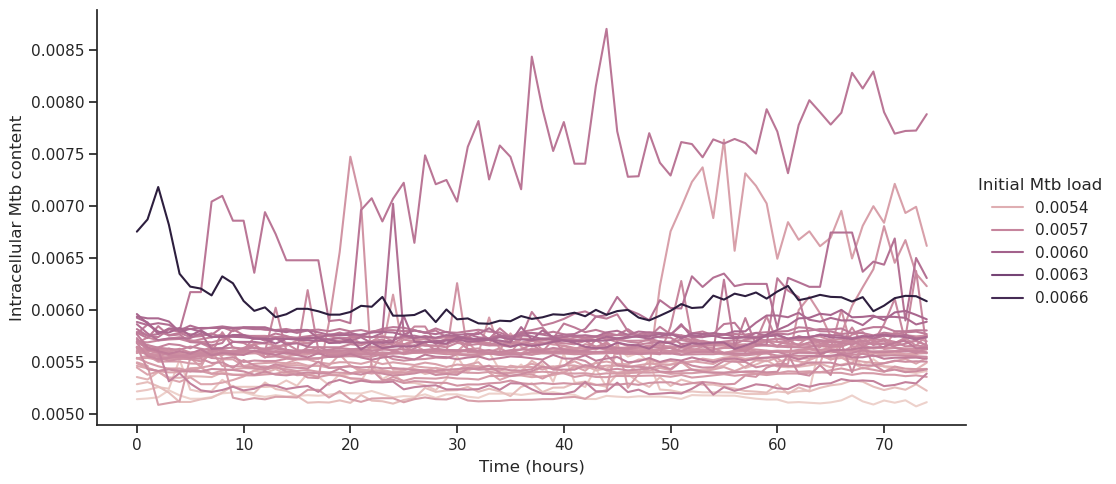

In [160]:
sns.relplot(data = tracks_df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Initial Mtb load', kind = 'line',
            aspect = 2,
           )

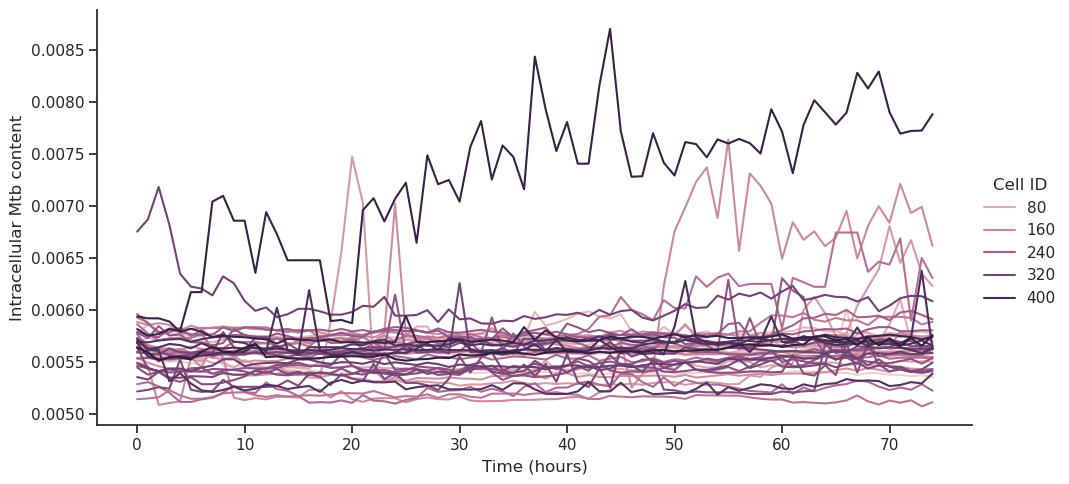

In [167]:
sns.relplot(data = tracks_df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Cell ID', kind = 'line',
            aspect = 2,
           )

<AxesSubplot:xlabel='Time (hours)', ylabel='Intracellular Mtb content'>

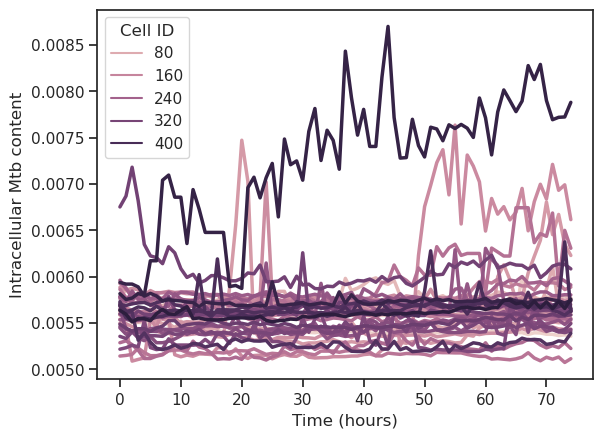

In [168]:
sns.lineplot(data=tracks_df,
             x = 'Time (hours)', 
             y = 'Intracellular Mtb content', 
             hue = 'Cell ID',
             linewidth=2.5)

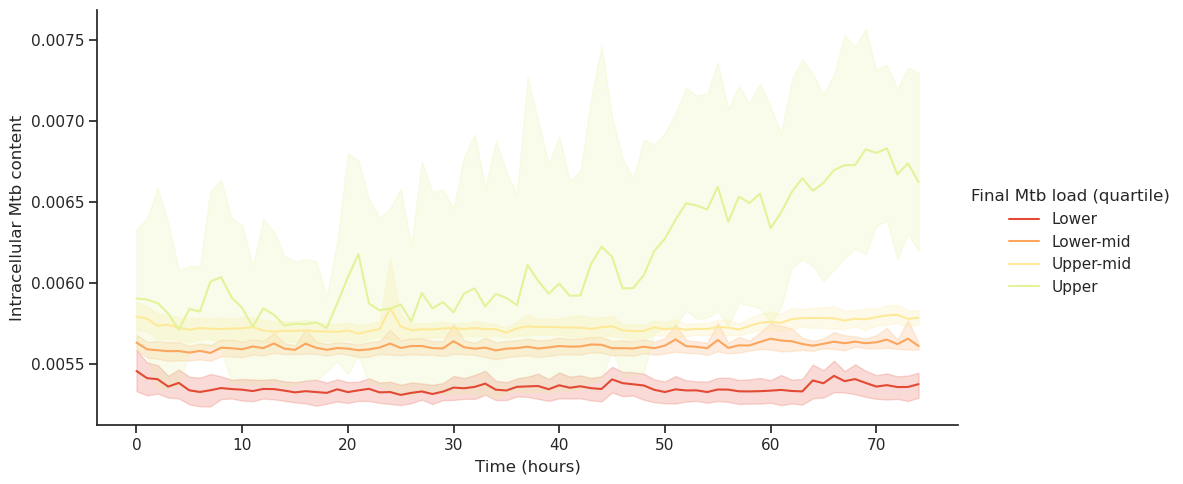

In [169]:
sns.relplot(data = tracks_df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Final Mtb load (quartile)', kind = 'line',
            aspect = 2,
           )

In [179]:
quartile

'Upper'

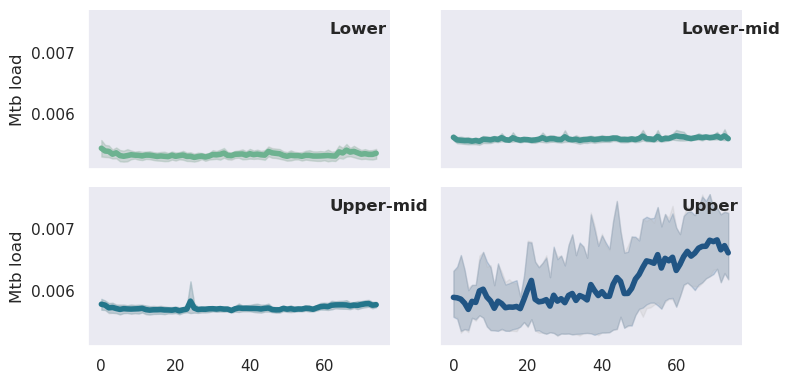

In [184]:
sns.set_theme(style="dark")
flights = sns.load_dataset("flights")

# Plot each year's time series in its own facet
g = sns.relplot(
    data=tracks_df,
    x = 'Time (hours)', 
    y = 'Intracellular Mtb content', 
    hue = 'Final Mtb load (quartile)',
    col = 'Final Mtb load (quartile)',
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=2, height=2, aspect=2, legend=False,
)

# Iterate over each subplot to customize further
for quartile, ax in g.axes_dict.items():
    
    # Add the title as an annotation within the plot
    ax.text(.8, .85, quartile, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
       data=tracks_df[tracks_df['Final Mtb load (quartile)'] == quartile],
        x = 'Time (hours)', 
        y = 'Intracellular Mtb content', # units="Time (hours)",
        estimator='mean', color=".7", linewidth=0.5, ax=ax,
    )

# Reduce the frequency of the x axis ticks
# ax.set_xticks(ax.get_xticks()[::2])

# # Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Mtb load")
g.tight_layout()

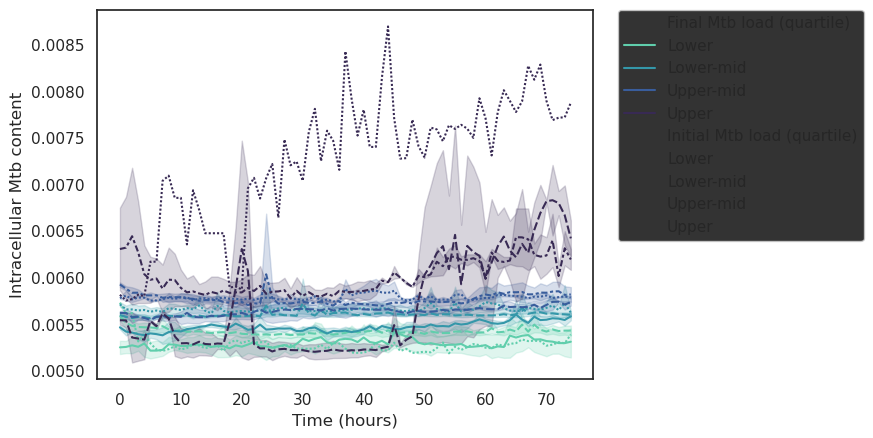

In [203]:
palette = sns.color_palette("mako_r", 4)
sns.lineplot(
    data=tracks_df, x="Time (hours)", y="Intracellular Mtb content",
    hue="Final Mtb load (quartile)", style="Initial Mtb load (quartile)",
    palette=palette
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


In [216]:
crop_df = tracks_df[0:375]

In [197]:
crop_df

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID,Initial Mtb load,Final Mtb load,Final Mtb load (quartile),Initial Mtb load (quartile)
53400,0,843.888977,9.895291,1423.0,0.005217,0.015092,0.958017,0.000000,WT,PZA,EC99,307,"(5, 6)",0.005217,0.005413,Lower,Lower
53401,1,842.016602,8.402156,1206.0,0.005233,0.017785,0.959472,2.394837,WT,PZA,EC99,307,"(5, 6)",0.005217,0.005413,Lower,Lower
53402,2,854.697998,12.947233,2331.0,0.005259,0.015358,0.938589,13.471286,WT,PZA,EC99,307,"(5, 6)",0.005217,0.005413,Lower,Lower
53403,3,853.580505,11.769628,1745.0,0.005243,0.015071,0.931874,1.623436,WT,PZA,EC99,307,"(5, 6)",0.005217,0.005413,Lower,Lower
53404,4,853.345703,12.378826,1993.0,0.005525,0.016826,0.929846,0.652882,WT,PZA,EC99,307,"(5, 6)",0.005217,0.005413,Lower,Lower
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54145,70,163.399994,183.899994,1220.0,0.005901,0.050616,0.685303,1.145538,WT,PZA,EC99,239,"(5, 6)",0.005961,0.005910,Upper-mid,Upper
54146,71,163.478424,182.802948,1020.0,0.005976,0.057905,0.501100,1.099846,WT,PZA,EC99,239,"(5, 6)",0.005961,0.005910,Upper-mid,Upper
54147,72,161.886673,183.028824,1006.0,0.005991,0.058907,0.538054,1.607698,WT,PZA,EC99,239,"(5, 6)",0.005961,0.005910,Upper-mid,Upper
54148,73,161.052887,183.222336,1021.0,0.005953,0.054625,0.548606,0.855947,WT,PZA,EC99,239,"(5, 6)",0.005961,0.005910,Upper-mid,Upper


In [ ]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# # Create the data
# rs = np.random.RandomState(1979)
# x = rs.randn(500)
# g = np.tile(list("ABCDEFGHIJ"), 50)
# df = pd.DataFrame(dict(x=x, g=g))
# m = df.g.map(ord)
# df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Compound", hue="Compound", aspect=4, height=4, palette=pal)

# Draw the densities in a few steps
g.map(sns.lineplot, 
      data = df,
      x = "Time (hours)",
      y = 'Intracellular Mtb content',
#       hue="Compound"
      #       bw_adjust=.5, 
      clip_on=False,
#       fill=True, alpha=1, linewidth=1.5
     )

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Time")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.75)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


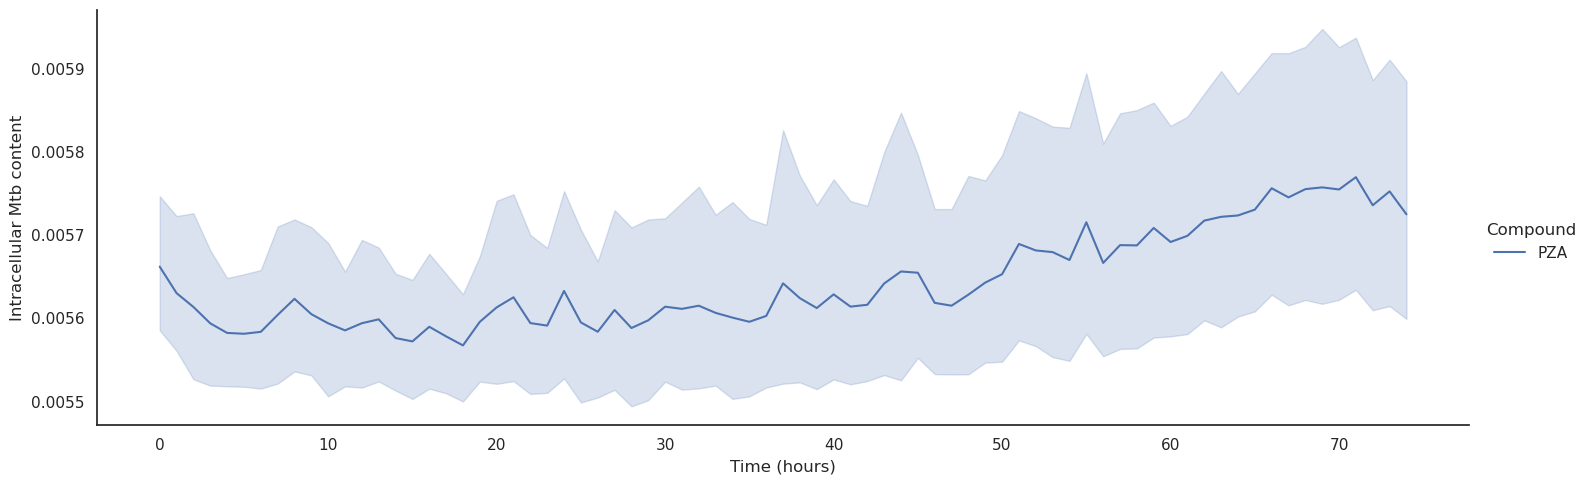

In [254]:
sns.relplot(data = tracks_df, 
            x = 'Time (hours)', 
            y = 'Intracellular Mtb content', 
            hue = 'Compound', kind = 'line',
            aspect = 3,
           )

## Want to isolate the extreme cases of this plot

#### pull corresponding images

In [13]:
row, column = tracks_df['Acquisition ID'].iloc[0]
images = tile.compile_mosaic(
                             image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_plane = 'sum_proj',
                             ).astype(np.uint16)

In [14]:
images

,Array,Chunk
Bytes,10.22 GiB,15.50 MiB
Shape,"(75, 2, 6048, 6048)","(1, 2, 2016, 2016)"
Count,16875 Tasks,675 Chunks
Type,uint16,numpy.ndarray


In [14]:
tracks_df.loc[tracks_df['Intracellular Mtb content'].idxmax()]

Time (hours)                         44
x                            922.763916
y                            375.779785
Area                             1703.0
Intracellular Mtb content        0.0087
Macroph. GFP expression        0.072102
Eccentricity                   0.796489
MSD                            4.293594
Strain                               WT
Compound                            PZA
Concentration                      EC99
Cell ID                             431
Acquisition ID                   (5, 6)
Name: 54569, dtype: object

In [15]:
tracks_df.loc[tracks_df['Intracellular Mtb content'].idxmin()]

Time (hours)                         73
x                              9.147012
y                            980.150269
Area                              619.0
Intracellular Mtb content      0.005074
Macroph. GFP expression        0.021289
Eccentricity                   0.787484
MSD                            3.421689
Strain                               WT
Compound                            PZA
Concentration                      EC99
Cell ID                             193
Acquisition ID                   (5, 6)
Name: 55498, dtype: object

In [16]:
cell_ID_193 = tracks_df[tracks_df['Cell ID']==193]
cell_ID_431 = tracks_df[tracks_df['Cell ID']==431]

In [17]:
cell_ID_431

,Time (hours),x,y,Area,Intracellular Mtb content,Macroph. GFP expression,Eccentricity,MSD,Strain,Compound,Concentration,Cell ID,Acquisition ID
54525,0,927.022827,392.380096,2544.0,0.005816,0.034374,0.841795,0.000000,WT,PZA,EC99,431,"(5, 6)"
54526,1,929.788879,390.037354,2705.0,0.005753,0.029524,0.513802,3.624843,WT,PZA,EC99,431,"(5, 6)"
54527,2,933.411438,386.697540,2202.0,0.005769,0.029265,0.838534,4.927198,WT,PZA,EC99,431,"(5, 6)"
54528,3,936.937927,392.752991,1498.0,0.005817,0.033970,0.826542,7.007468,WT,PZA,EC99,431,"(5, 6)"
54529,4,939.611145,384.385254,1952.0,0.005800,0.031106,0.779231,8.784368,WT,PZA,EC99,431,"(5, 6)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54595,70,894.532715,346.507751,2001.0,0.007900,0.062009,0.604818,4.101465,WT,PZA,EC99,431,"(5, 6)"
54596,71,896.276428,348.002594,2308.0,0.007694,0.060276,0.662960,2.296757,WT,PZA,EC99,431,"(5, 6)"
54597,72,895.013977,346.771790,2147.0,0.007720,0.061512,0.587702,1.763140,WT,PZA,EC99,431,"(5, 6)"
54598,73,895.066040,349.307098,2286.0,0.007723,0.059950,0.680616,2.535843,WT,PZA,EC99,431,"(5, 6)"


### Removing a track from the df because it is broken

In [182]:
tracks_df.drop(tracks_df[tracks_df['Cell ID'] == 329].index, inplace = True)

In [183]:
tracks_df.loc[tracks_df['Intracellular Mtb content'].idxmax()]

Time (hours)                          24
x                            1020.042847
y                            1044.448242
Area                              3755.0
Intracellular Mtb content        0.00702
Macroph. GFP expression         0.027315
Eccentricity                    0.955435
MSD                            10.748026
Strain                                WT
Compound                             PZA
Concentration                       EC99
Cell ID                              141
Acquisition ID                    (5, 6)
Name: 55824, dtype: object

## Select one cell as a seperate df

In [184]:
sc_df = tracks_df[tracks_df['Cell ID']==141]
ID = list(sc_df['Cell ID'])[0]
acq_ID = list(sc_df['Acquisition ID'])[0]